<a href="https://colab.research.google.com/github/Archibasov-D/nanolab_optimization_Multiplexer/blob/main/Simplest_system_optimization_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import cmath
from scipy.linalg import dft
import torch
import scipy as sp
from PIL import Image, ImageChops
import math
import matplotlib as mpl
from scipy.optimize import minimize

In [2]:
print(torch.cuda.is_available())
device = torch.device('cpu')

False


In [22]:
# задание профиля кругового отверстия 70х70 точек
wave_length = 1500 * 1e-9
N1 = 30#20 # y
N2 = 30#20 # x
T = 0.7*wave_length
k_wave = 2*np.pi/wave_length
d = 40*wave_length #30

# вычисление T0
def T0_vec_diag_calculation(parameter_): #      <- вектор         # ndarray parameter переходит в Torch tensor
  T0 = np.exp(1j*np.reshape(parameter_,(N1,N2)))
  T0_vec_diag = torch.tensor(np.diag(np.reshape(T0,(N1*N2,))), dtype=torch.cfloat).to(device=device)
  return T0_vec_diag #TORCH

# расчёт матрицы
#нужно описать пропогаторы
#получение фурье матрицы
# определение пропогатора
fX = np.fft.fftfreq(N1,T) #fY идентичны - Правильно сделано, возвращает 1/м
fY = np.fft.fftfreq(N2,T) # fX.copy()
H_propogator_d=np.zeros((N1,N2),dtype='complex')
for i in range(N1):
  for j in range(N2):
    H_propogator_d[i,j] = np.exp(1j*k_wave*d*cmath.sqrt(1-np.power(wave_length*fX[j],2)-np.power(wave_length*fY[i],2))) # квадрат
#####отправляем это всё на GPU
W = torch.tensor(dft(N1) ,dtype=torch.cfloat).to(device=device)
W_rev = torch.tensor(inv(dft(N1)),dtype=torch.cfloat).to(device=device)
H_vec_diag = torch.tensor(np.diag(np.reshape(H_propogator_d,(N1*N2))), dtype=torch.cfloat).to(device=device)
WW = torch.kron(W,W)
W_rW_r = torch.kron(W_rev,W_rev)


parameter_vector= (N1*N2)*[np.pi]
parameter_vector = np.array(parameter_vector)
#parameter_vector= np.zeros((N1*N2)) #<- вектор N1*N2 #np.random.rand((N1*N2))#


M = torch.matmul(W_rW_r, torch.matmul(H_vec_diag,WW)) # отвечает за распространение

def intermediate_matrix_calculation_for_simple_system(parameter_vector):# параметры ВСЁ TORCH
  #B = torch.matmul(W_rW_r,torch.matmul(H_vec_diag,torch.matmul(WW,torch.matmul(T_phase_mask, torch.matmul( W_rW_r, torch.matmul(H_vec_diag, WW))))))
  B = torch.matmul(M,T0_vec_diag_calculation(parameter_vector))#torch.matmul(M,torch.matmul(T0_vec_diag_calculation(parameter_vector), M))
  return B


In [23]:
print("макс радиальный волновой вектор",max(fX)*2*np.pi)

макс радиальный волновой вектор 2792526.803190927


In [24]:

def normalize_vector(U_vector):
  """
  Возвращает вектор нормированный на энергию и прежнюю норму

  """
  norma = torch.sqrt(torch.absolute(torch.matmul(torch.conj(U_vector).T, U_vector)))
  return U_vector/norma, float(norma )

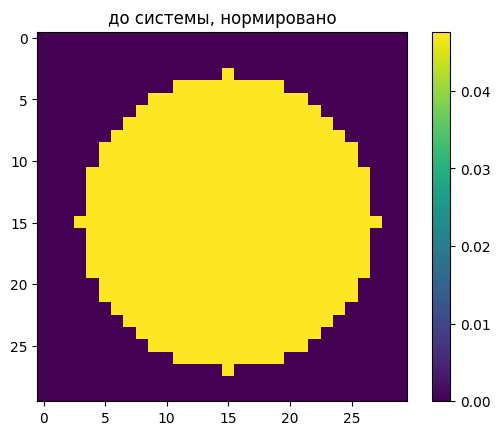

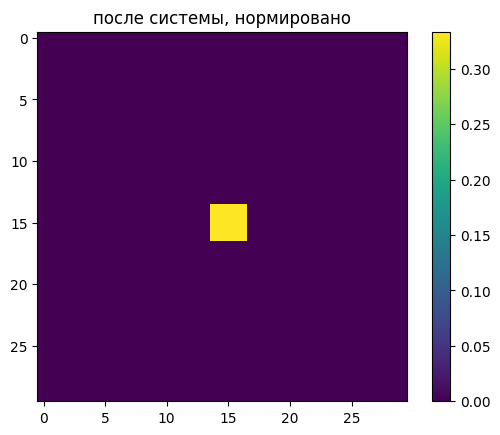

In [27]:
# Задание изображения:
radius = 12#7
input = np.zeros((N1,N2), dtype='complex')
for i in range(N1):
  for j in range(N2):
    if np.sqrt((0 - (i - N1//2  ))**2+(0 - (j - N2//2  ))**2)  <= radius: #np.sqrt((0 - (i - N1//2 - N1%2))**2+(-(N2//2 - N2%2 + 5*T + radius) - (j - N2//2 - N2%2))**2)  < radius:
      input[i,j] = 1

input_tensor = torch.reshape(torch.tensor(input, dtype=torch.cfloat), (N1*N2,1))
U_initial_full_size,_ = normalize_vector(input_tensor)

output = np.zeros((N1,N2), dtype='complex')
for i in range(N1):
  for j in range(N2):
    if np.sqrt((0 - (i - N1//2  ))**2+(+0*( N2//2 - radius - 4) - (j - N2//2  ))**2)  < 2.0:#np.sqrt((0 - (i - N1//2 - N1%2))**2+(-(N2//2 - N2%2 + 5*T + radius) - (j - N2//2 - N2%2))**2)  < radius:
      output[i,j] = 1

output_tensor = torch.reshape(torch.tensor(output, dtype=torch.cfloat), (N1*N2,1))
U_target_full_size,_ = normalize_vector(output_tensor)

plt.title(f'до системы, нормировано')
plt.imshow(np.absolute(torch.reshape(U_initial_full_size,(N1,N2))))#np.absolute(torch.reshape(initial_U,(N1,N2))))
plt.colorbar()
plt.show()


plt.title(f'после системы, нормировано')
plt.imshow(np.absolute(torch.reshape(U_target_full_size,(N1,N2))))#np.absolute(torch.reshape(initial_U,(N1,N2))))
plt.colorbar()
plt.show()

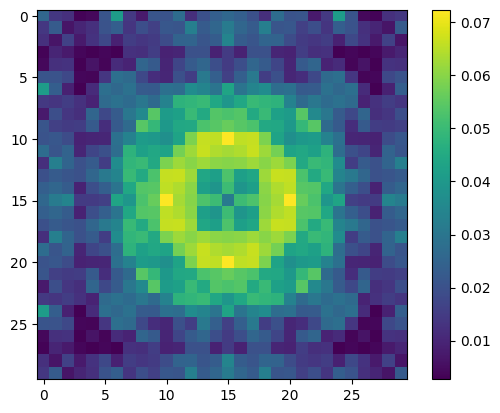

In [28]:
plt.imshow(np.absolute(torch.reshape(torch.matmul(intermediate_matrix_calculation_for_simple_system(parameter_vector),U_initial_full_size),(N1,N2))))#np.absolute(torch.reshape(initial_U,(N1,N2))))
plt.colorbar()
plt.show()

In [29]:
def chek__front_lens(x,y,z):
  phpc = (np.pi*2)/wave_length * (z - np.sqrt(pow(z,2) + pow(x,2) +pow(y,2)))#(np.pi*2)/wave_length*np.sin(np.pi/5)*y##(np.pi*2)/wave_length * (z - np.sqrt(pow(z,2) + pow(x,2) +pow(y,2)))#(np.pi*2)/wave_length*np.sin(np.pi/6)*y#-(np.pi*2)/(z*wave_length) * (pow(x,2) +pow(y,2))
  return math.fmod(phpc, np.pi*2)

In [30]:
pop = np.zeros((N1,N2))
for i in range(N1):
  for j in range(N2):
    pop[i,j] = chek__front_lens( (i - (N1)//2)*T, (j - (N2)//2)*T, d)
pop = np.reshape(pop, (N1*N2))
pop = np.random.rand((N1*N2))

In [10]:
alpha = 1
resize = 1

In [11]:
 def overlap_integral(parameter_): #ВОТ ЗДЕСЬ ПРОБЛЕМА С CASTING COMPLEX VALUES DISAGARD
  A = intermediate_matrix_calculation_for_simple_system(parameter_)
  U_ = torch.matmul(A,U_initial_full_size) #на случай одной пары - для минимазации, полноразмерные векторы
  return -np.power(float((torch.absolute(torch.matmul(torch.conj(U_target_full_size).T, U_))**2)[0,0]), alpha)*resize

In [12]:
def grad_overlap_integral(parameter_):
  # <- векторные вычисления, можно большой размерности передавать, вектор U_target_ - будет из нулей создавать
  A = intermediate_matrix_calculation_for_simple_system(parameter_)
  A_inv = torch.linalg.inv(A)
  U_ = torch.matmul(A,U_initial_full_size) #на случай одной пары - для минимазации, полноразмерные векторы
  V = torch.mul(torch.matmul(torch.conj(torch.t(U_)),U_target_full_size) , torch.matmul(torch.t(A),torch.conj(U_target_full_size)))
  H = torch.matmul(A_inv, M)
  F = torch.matmul(A_inv, U_)#torch.matmul(M, torch.matmul(A_inv, U_))
  phase_mask_vector = torch.tensor(np.exp(1j*np.reshape(parameter_,(N1*N2,1))), dtype=torch.cfloat).to(device=device)
  #print('V',torch.diag(torch.reshape(torch.mul(phase_mask_vector , F), (N1*N2,))))
  return -2*resize*alpha*np.power(float((torch.absolute(torch.matmul(torch.conj(U_target_full_size).T, U_))**2)[0,0]), alpha-1)*np.array((torch.imag(torch.matmul(torch.t(V),torch.matmul(H,torch.diag(torch.reshape(torch.mul(phase_mask_vector , F), (N1*N2,))))))).cpu(), copy = True)
  #np.array((2*torch.imag( torch.multiply(torch.conj(torch.matmul(torch.conj(U_target_full_size).T, U_)),torch.multiply(torch.conj(V),U_) ))).cpu())

In [31]:
overlap_integral(pop)

-0.015402979217469692

In [14]:
grad_overlap_integral(pop)

array([[-2.48096930e-03,  6.27911242e-04,  1.33199384e-03,
         2.03214888e-03, -1.02390186e-03,  2.99455854e-03,
        -1.36379851e-03, -2.39456422e-03, -1.11172383e-03,
         1.18644224e-04,  3.25999665e-03, -1.75170344e-03,
         1.24577829e-03, -2.14179303e-03,  6.67652756e-04,
        -5.55228500e-04, -1.10515277e-03,  5.84845617e-03,
         4.11682558e-05,  2.41504610e-03,  4.37785551e-04,
         3.09266662e-03, -5.93675941e-04,  1.80917955e-03,
        -2.17728375e-04,  2.65273964e-04, -2.12104106e-03,
        -2.77307612e-04, -3.67802801e-03,  8.97297985e-04,
        -1.76100992e-03,  9.26486216e-04, -1.05390174e-03,
         1.57006155e-03, -4.55454038e-03, -1.36790960e-03,
         2.63824989e-03,  2.47266702e-03, -1.16626790e-03,
        -9.20391409e-04, -2.41372432e-03, -5.51814737e-04,
        -4.74611716e-03,  3.96052899e-04, -1.02876707e-04,
         2.67121219e-03, -1.02697499e-03, -1.17810239e-04,
         3.15362704e-04,  9.06125933e-05, -2.21936055e-0

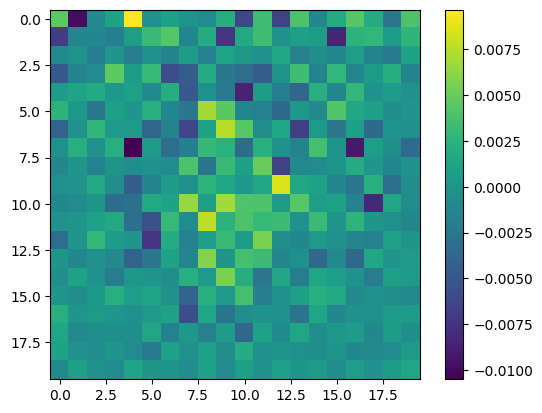

In [15]:
plt.imshow(np.reshape(grad_overlap_integral(parameter_vector),(N1,N2)))
plt.colorbar()
plt.show()

# будет ли проблема что фурье будет через границу считать - не физично

In [32]:
bnds = ((-2*np.pi, 2*np.pi),)*(N1*N2) #bounds=bnds,
result = minimize(overlap_integral, parameter_vector, method='L-BFGS-B',bounds=bnds, jac='3-point', options={'eps':1e-3,'maxls': 25,'gtol':1e-20,'ftol':1e-20,'maxiter' : 9})

In [33]:
print(result)

  message: STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
  success: False
   status: 1
      fun: -0.2866927683353424
        x: [ 3.142e+00  3.142e+00 ...  3.142e+00  3.142e+00]
      nit: 5
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
     nfev: 18010
     njev: 10
 hess_inv: <900x900 LbfgsInvHessProduct with dtype=float64>


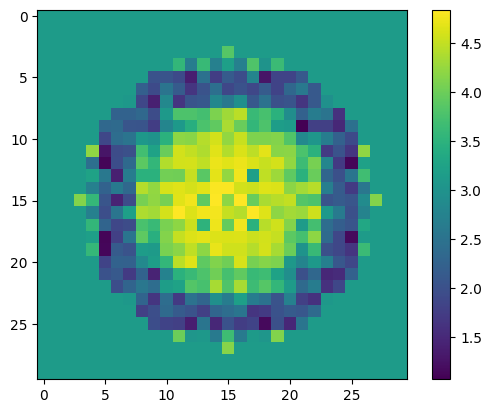

In [34]:
plt.imshow(np.reshape(result.x,(N1,N2)))
plt.colorbar()
plt.show()

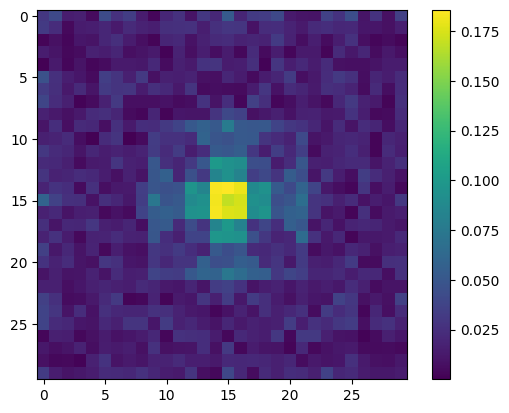

In [35]:
plt.imshow(np.absolute(torch.reshape(torch.matmul(intermediate_matrix_calculation_for_simple_system(result.x),U_initial_full_size),(N1,N2))))#np.absolute(torch.reshape(initial_U,(N1,N2))))
plt.colorbar()
plt.show()